In [73]:
import numpy as np
import torch
from torch import Tensor
from numpy import ndarray
from typing import Tuple, Union, Optional
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

set_t = {
    "dtype": torch.float32,
    "device": torch.device("cuda"),
}

In [76]:
# Function to define the unit cube vertices
def get_cube_vertices(x_L: Tensor, x_U: Tensor) -> ndarray:
    """
    Given the lower and upper bounds on the input domain, generate vertices in lexicographical order by using the cartesian product operator. 
    :param x_L: Input lower bounds
    :param x_U: Input upper bounds
    :return:    Vertices in lexicographic order
    """
    x_L = x_L.reshape(1, -1)
    x_U = x_U.reshape(1, -1)
    cat_tensor = torch.cat((x_L, x_U), 0).permute(1, 0)
    points = torch.cartesian_prod(*cat_tensor)
    return points.detach().cpu().numpy()


# Function to define the faces of a unit cube
def unit_cube_faces():
    # Each face consists of 4 vertices (indices refer to the vertex array)
    return [[0, 1, 5, 4],  # Bottom face
        [2, 3, 7, 6],  # Top face
        [0, 1, 3, 2],  # Front face
        [4, 5, 7, 6],  # Back face
        [0, 2, 6, 4],  # Left face
        [1, 3, 7, 5]]   # Right face

def plot_plane(
        ax, 
        normal: ndarray, 
        D: float, 
        xlim: list[Union[float, int]], 
        ylim: list[Union[float, int]]
):
    """
    
    :param ax:      Graph plotting object
    :param normal:  Plane coefficients
    :param D:       Plane offset
    :param xlim:    Graph x limits
    :param ylim:    Graph y limits
    :return: 
    """
    A, B, C = normal
    xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 10), np.linspace(ylim[0], ylim[1], 10))
    zz = (D - A * xx - B * yy) / C
    ax.plot_surface(xx, yy, zz, alpha=0.5)
    
def plot_cube(ax, vertices, faces):
    """
    
    :param ax:          Graph plotting object
    :param vertices:    Cube vertex coordinates
    :param faces:       Index mask into vertices describing the face in clockwise order
    :return: 
    """
    # Plot the cube's faces
    for face in faces:
        verts = [vertices[face]]
        ax.add_collection3d(Poly3DCollection(verts, alpha=0.2, edgecolor='k'))
        
        
def generate_cube_edges() -> list[Tuple[int, int]]:
    """
    These are the edges for vertices represented by their lexicographic order. 
    :return: 
    """
    edges = []
    num_vertices = 8  # 2^3 for a cube

    for v1 in range(num_vertices):  # Vertices represented as 0 to 7 (3-bit numbers)
        for bit in range(3):  # Flip each of the 3 bits (positions 0, 1, 2)
            v2 = v1 ^ (1 << bit)  # XOR to flip the 'bit'-th bit
            if v2 > v1:  # Ensure we only add each edge once
                edges.append((v1, v2))
    
    return edges
    
def plot_intersection(ax, vertices, normal, D):
    """
    
    :param ax:          Graph plotting object
    :param vertices:    Cube vertex coordinates
    :param normal:      Plane normal coefficients
    :param D:           Plane offset
    :return: 
    """
    A, B, C = normal
    # Compute distance from each vertex to the plane
    distances = A * vertices[:, 0] + B * vertices[:, 1] + C * vertices[:, 2] - D

    # Identify vertices below and above the plane
    below = vertices[distances < 0]
    above = vertices[distances >= 0]

    # Plot intersection points
    ax.scatter(below[:, 0], below[:, 1], below[:, 2], color='r', label='Below Plane')
    ax.scatter(above[:, 0], above[:, 1], above[:, 2], color='b', label='Above Plane')
    
def calculate_intersection(edges: ndarray, normal: ndarray, D: float, verbose=False
                           ) -> Tuple[ndarray, ndarray, ndarray]:
    """
    
    :param edges:   Edge vertex pairs
    :param normal:  Plane normal coefficients
    :param D:       Plane offset
    :param verbose: Prints debugging logs
    :return: 
    """
    # convert to Tensors
    edges = torch.tensor(edges, **set_t)
    normal = torch.tensor(normal, **set_t)
    batches = edges.shape[0]
    
    # For 3D boxes, batch = 12
    Vis = edges[:, 0, :].unsqueeze(2)  # (batch x 3 x 1)
    Vjs = edges[:, 1, :].unsqueeze(2)  # (batch x 3 x 1)
    e_ij = Vjs - Vis    # (batch x 3 x 1)
    normal_exp = normal.reshape(1, 1, -1).expand(batches, -1, -1)
    if verbose:
        print(f"Shape Vis: {Vis.shape}")
        print(f"Shape Vjs: {Vjs.shape}")
        print(f"Shape Eij: {e_ij.shape}")
        print(f"Shape Normal Expanded: {normal_exp.shape}")
            
    
    lambdas = (D - normal_exp.bmm(Vis)) / normal_exp.bmm(e_ij)
    lambdas = lambdas.squeeze()  # squeeze out singleton dimensions
    
    if verbose:
        print(f"Lambdas (num {len(lambdas)}): \n{lambdas}")
        
    # create an intersection mask; intersection only happens when lambda is in range [0,1]
    i_mask = torch.logical_and(0. <= lambdas, lambdas <= 1.)
    num_intersections = i_mask.to(dtype=torch.int).sum()
    
    if verbose:
        print(f"Intersection mask ({num_intersections}): {i_mask}")
    
    if num_intersections > 0:
        Vis_m = Vis.squeeze()[i_mask]  # (num inter. x 3)
        lambdas_m = lambdas.unsqueeze(1)[i_mask]  # (num inter. x 1)
        e_ij_m = e_ij.squeeze()[i_mask]  # (num inter. x 3)
        if verbose:
            print(f"Shape Vis_m: {Vis_m.shape}")
            print(f"Shape lambdas_m: {lambdas_m.shape}")
            print(f"Shape e_ij_m: {e_ij_m.shape}")
        intersection_pts = Vis_m + lambdas_m * e_ij_m
    else:
        intersection_pts = torch.empty((0, 3))
    
    if verbose:
        print(f"Intersection points (shape {intersection_pts.shape}): {intersection_pts}")
    
    # convert results back to numpy
    lambdas_np = lambdas.detach().cpu().numpy()
    intersection_mask_np = i_mask.detach().cpu().numpy()
    intersection_pts_np = intersection_pts.detach().cpu().numpy()
    
    return lambdas_np, intersection_mask_np, intersection_pts_np

def volume_of_tetrahedron(a: ndarray, b: ndarray, c: ndarray, d: ndarray):
    """
    Calculate the volume of a tetrahedron with vertices a, b, c, d.
    :param a:   Vertex 1 (numpy array)
    :param b:   Vertex 2 (numpy array)
    :param c:   Vertex 3 (numpy array)
    :param d:   Vertex 4 (numpy array)
    :return:    Volume of the tetrahedron
    """
    return np.abs(np.dot(a - d, np.cross(b - d, c - d))) / 6.0

def calculate_volume_above_plane(vertices: ndarray, intersection_pts: ndarray, normal: ndarray, D: float):
    """
    Calculate the volume above the plane inside the cube.
    :param vertices:            Cube vertex coordinates
    :param intersection_pts:    Points of intersection between cube edges and plane
    :param normal:              Normal vector of the plane
    :param D:                   Plane offset
    :return:                    Volume above the plane inside the cube
    """
    A, B, C = normal
    # Compute distances of each vertex from the plane
    distances = A * vertices[:, 0] + B * vertices[:, 1] + C * vertices[:, 2] - D

    # Separate vertices above the plane
    above_vertices = vertices[distances >= 0]
    
    # Combine above vertices with intersection points to form the polyhedron
    polyhedron_vertices = np.vstack([above_vertices, intersection_pts])

    # Triangulate the polyhedron and calculate volume of each tetrahedron
    reference_point = np.array([0, 0, 0])  # You can choose a reference point inside the cube
    total_volume = 0.0
    for i in range(1, len(polyhedron_vertices) - 2):
        a, b, c = polyhedron_vertices[0], polyhedron_vertices[i], polyhedron_vertices[i + 1]
        total_volume += volume_of_tetrahedron(reference_point, a, b, c)

    return total_volume

def visualize_cube_intersection_with_plane(x_L: Tensor, x_U: Tensor, normal: ndarray, D: float, verbose=False):
    """
    
    :param x_L:     Input lower bounds
    :param x_U:     Input upper bounds
    :param normal:  Plane normal coefficients
    :param D:       Plane offset
    :param verbose: Print debugging logs
    :return: 
    """
    # Create 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Define cube vertices and faces
    vertices = get_cube_vertices(x_L, x_U)
    edge_masks = generate_cube_edges()
    edges = vertices[edge_masks, :]
    faces = unit_cube_faces()
    
    if verbose:
        print(f"Vertices (num {len(vertices)}): \n{vertices}")
        print(f"Edges (num {len(edges)}): \n{edges}")
        
    lambdas, intersection_mask, intersection_pts = calculate_intersection(edges, normal, D, verbose)
    
    if len(intersection_pts > 0):
        # intersection occurs with the bounding box and the plane
        ax.scatter(intersection_pts[:, 0], intersection_pts[:, 1], intersection_pts[:, 2], color='g', label='Intersection points')
        
    intersection_volume = calculate_volume_above_plane(vertices, intersection_pts, normal, D)
    print(f"Volume intersection: {intersection_volume}")
    print(f"Total volume: {(x_U - x_L).prod()}")

    # Plot the cube
    plot_cube(ax, vertices, faces)

    # Plot the intersecting plane
    plot_plane(ax, normal, D, [0, 1], [0, 1])

    # # Plot the intersection of the plane with the cube
    plot_intersection(ax, vertices, normal, D)

    # Label the axes
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    plt.legend()
    plt.show()

Volume intersection: 0.9166666666666666
Total volume: 1.0


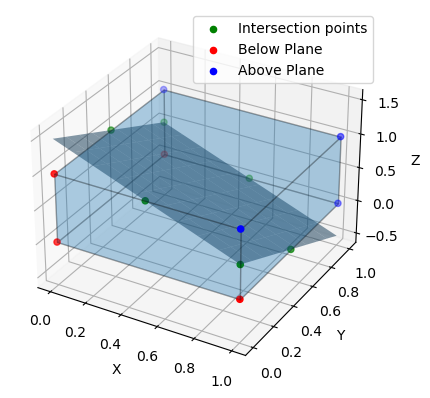

In [77]:
# plane equation <normal, x> + D = 0
normal = np.array([1, 1, 1])
D = 1.5

# input bounding box
x_L = torch.zeros(3)
x_U = torch.ones(3)

visualize_cube_intersection_with_plane(x_L, x_U, normal, D, False)